In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/DL4US/Final\ Assignment

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/DL4US/Final Assignment


In [0]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
import WAI022 as WAI
mainWindow = WAI.MainWindow()

In [0]:
def generate_new_data(n):
  for i in range(n):
    mainWindow.mainLoop()
    if (i+1)%100 == 0:
        print(".", end="")
    if (i+1)%10000 == 0:
        print("")
  print("")
  learning = pd.DataFrame(mainWindow.ais[0].learningData)
  learning.columns = mainWindow.ais[0].getLearningDataNames()
  learning.set_index(['Time'], inplace=True)
  teacher = pd.DataFrame(mainWindow.ais[0].teacherData)
  teacher.columns = mainWindow.ais[0].getTaecherDataNames()
  teacher.Time = teacher.Time.shift(-1)
  teacher.set_index(['Time'], inplace=True)
  mainWindow.ais[0].learningData = []
  mainWindow.ais[0].teacherData = []
  return teacher.join(learning)

In [0]:
def load_data(n):
    data = generate_new_data(n)
    data = data.iloc[0:-1]
#     y_train = data.loc[:,['Pain']]
#    y_train['Dammy'] = 1 - y_train['Pain']
    y_train = data['Pain'].values.astype('float32')
    x_train = data.drop(columns=['Time','Pain']).values.astype('float32')
    columns = data.columns.tolist()[1:]
    return (x_train, y_train, columns)

In [0]:
import keras.backend as K

# precision, recall, f-measureを定義する
THRESHOLD = 0.5

#precision = selectivity
def P(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), THRESHOLD), 'float32'))
    pred_positives = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), 'float32'))

    precision = true_positives / (pred_positives + K.epsilon())
    return precision

#recall = sensitivity
def R(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), THRESHOLD), 'float32'))
    poss_positives = K.sum(K.cast(K.greater(K.clip(y_true, 0, 1), THRESHOLD), 'float32'))

    recall = true_positives / (poss_positives + K.epsilon())
    return recall

#f-measure
def F(y_true, y_pred):
    p_val = P(y_true, y_pred)
    r_val = R(y_true, y_pred)
    f_val = 2*p_val*r_val / (p_val + r_val)

    return f_val

Using TensorFlow backend.


## 学習データの準備

In [0]:
def split_pos_neg(x, y):
  x_pos, y_pos, x_neg, y_neg = [], [], [], []
  for i in range(y.shape[0]):
    ans = y[i]
    if ans == 1.0:
      x_pos.append(x[i])
      y_pos.append(y[i])
    else:
      x_neg.append(x[i])
      y_neg.append(y[i])
  print("pos neg: ", end="")
  print(len(x_pos), len(x_neg))
  return x_pos, y_pos, x_neg, y_neg

In [0]:
import os
import pickle

if os.path.isfile('dataset_10k.pkl'):
  with open('dataset_10k.pkl', 'rb') as file:
    x_val, y_val, x_pos, y_pos, x_neg, y_neg = pickle.load(file)
else:
  print('Creating a new data set...')
  x_val, y_val, _ = load_data(10000)

  train_target_n = 10000
  x_pos, y_pos, x_neg, y_neg = [], [], [], []
  while True:
    x, y, columns = load_data(5000)
    x_rec = np.concatenate([x_rec, x]) if 'x_rec' in globals() else x
    y_rec = np.concatenate([y_rec, y]) if 'y_rec' in globals() else y

    x_pos_tmp, y_pos_tmp, x_neg_tmp, y_neg_tmp = split_pos_neg(x, y)
    x_pos, y_pos = x_pos + x_pos_tmp, y_pos + y_pos_tmp
    x_neg, y_neg = x_neg + x_neg_tmp, y_neg + y_neg_tmp

    print(min(len(x_pos), len(x_neg)), "/", train_target_n)
    if len(x_pos) > train_target_n:
      if len(x_neg) > train_target_n:
        break

  pickle_data = [x_val, y_val, x_pos, y_pos, x_neg, y_neg]
  with open('dataset_10K.pkl', 'wb') as file:
    pickle.dump(pickle_data , file)

In [0]:
#多い方に合わせて、少ない方を複製（pos/negそれぞれデータ数としてはおおよそtrain_target_n * multiply_ratioになる）
if len(x_pos) > len(x_neg):
  multiply_ratio = (len(x_pos) - 1) // len(x_neg) + 1 #切り上げ処理
  x_neg = np.tile(x_neg, (multiply_ratio, 1))[:len(x_pos)]
  y_neg = np.tile(y_neg, multiply_ratio)[:len(y_pos)]
else:
  multiply_ratio = (len(x_neg) - 1) // len(x_pos) + 1 #切り上げ処理
  x_pos = np.tile(x_pos, (multiply_ratio, 1))[:len(x_neg)]
  y_pos = np.tile(y_pos, multiply_ratio)[:len(y_neg)]

## 性能確認用メソッド

In [0]:
def evaluate(x, y, y_pred, threshold = 0.5):
  tp, fp, fn, tn = [[],[]], [[],[]], [[],[]], [[],[]]
  for i in range(y.shape[0]):
    pred = y_pred[i][0]
    ans = y[i]
    if pred > threshold:
      if ans == 1.0:
        tp[0].append(x[i])
        tp[1].append(y[i])
      else:
        fp[0].append(x[i])
        fp[1].append(y[i])
    else:
      if ans == 1.0:
        fn[0].append(x[i])
        fn[1].append(y[i])
      else:
        tn[0].append(x[i])
        tn[1].append(y[i])
  print("tp fp fn tn: ", end="")
  print(len(tp[0]), len(fp[0]), len(fn[0]), len(tn[0]))
  return tp, fp, fn, tn

## 学習モデルの構築


https://qiita.com/ryouta0506/items/fb6a8976c49ae87f54de

https://aws.amazon.com/jp/blogs/news/training-models-with-unequal-economic-error-costs-using-amazon-sagemaker/

In [0]:
def custom_loss_wrapper(fn_cost=1, fp_cost=1):
    def custom_loss(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost):
        h = K.ones_like(y_pred)
        fn_value = fn_cost * h
        fp_value = fp_cost * h
        loss = -K.sum(y_true*K.log(y_pred+K.epsilon())*fn_value + (1-y_true)*K.log(1-y_pred+K.epsilon())*fp_value)
        return loss

    return custom_loss

In [0]:
loss_hist = []
val_loss_hist = []
P_hist = []
val_P_hist = []
R_hist = []
val_R_hist = []

In [0]:
transfer_weights = False

In [0]:
transfer_weights = True
transfer_target = [1, 2, 3]

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, MaxPooling1D, Lambda
from keras import regularizers
from keras import optimizers
from keras import backend as K

if transfer_weights and 'model' in globals():
  weights = [[], [], [], [], []]
  for i in transfer_target:
    weights[i] = model.layers[i].get_weights()
else:
  if 'weights' in globals(): del weights

inputs = Input(shape=(276,))
common_layer = Dense(128, activation='relu', kernel_initializer='he_normal', use_bias=True, kernel_regularizer=regularizers.l1(2))(inputs)
x = Dense(16, activation='sigmoid', kernel_initializer='glorot_normal', use_bias=True, kernel_regularizer=regularizers.l1_l2(l1 = 1, l2 = 0.1))(common_layer)
prediction_pos = Lambda(lambda x: K.max(x, axis=1, keepdims=True), name='prediction_pos')(x)
x = Dense(16, activation='sigmoid', kernel_initializer='glorot_normal', use_bias=True, kernel_regularizer=regularizers.l1_l2(l1 = 1, l2 = 0.1))(common_layer)
prediction_neg = Lambda(lambda x: K.max(x, axis=1, keepdims=True), name='prediction_neg')(x)
w_binary_crossentropy = custom_loss_wrapper(0.01, 1)   # カスタムコスト関数
model = Model(inputs=inputs, outputs=[prediction_pos, prediction_neg])
model.compile(loss=w_binary_crossentropy, optimizer=optimizers.Adam(lr=0.01), metrics=[P, R])

if transfer_weights and 'weights' in globals():
  for i in transfer_target:
      model.layers[i].set_weights(weights[i])

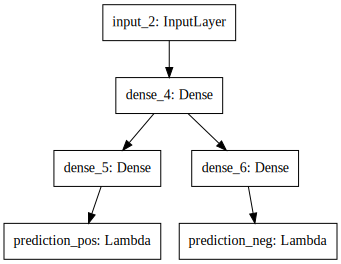

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 以降を繰り返し処理

0
tp fp fn tn: 14 7 574 58888
tp fp fn tn: 5361 1 53534 587


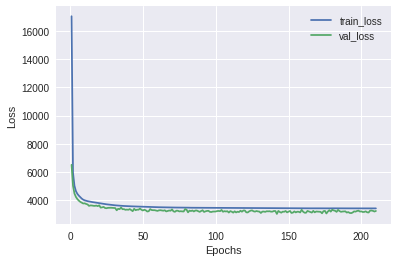

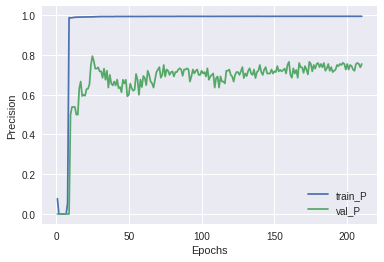

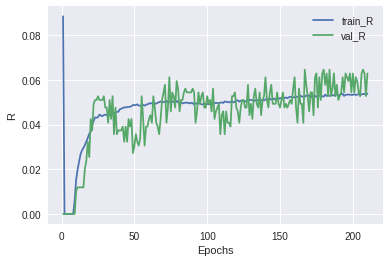

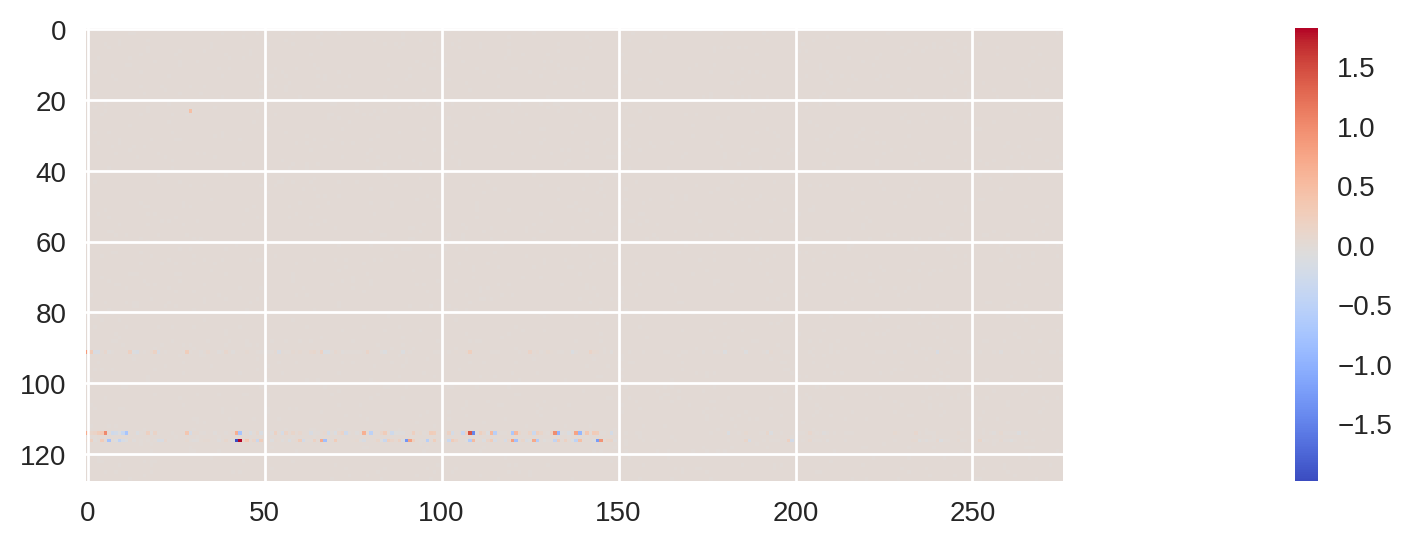

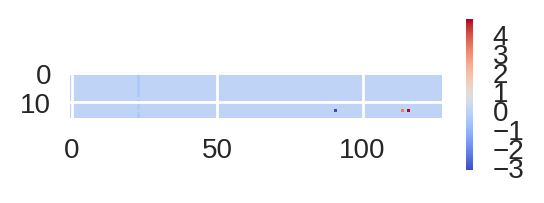

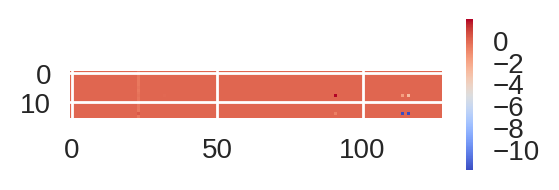

1
tp fp fn tn: 16 7 572 58888
tp fp fn tn: 5200 0 53695 588


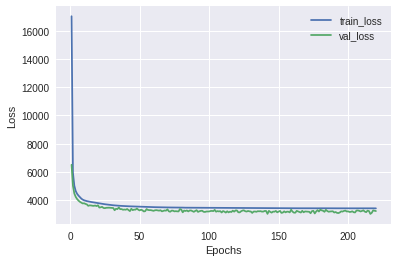

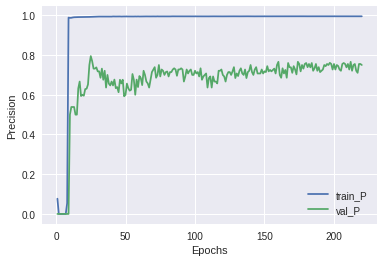

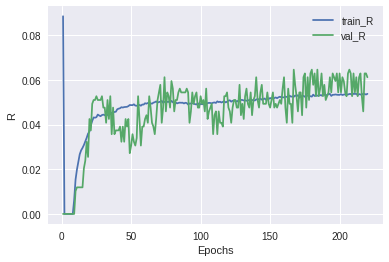

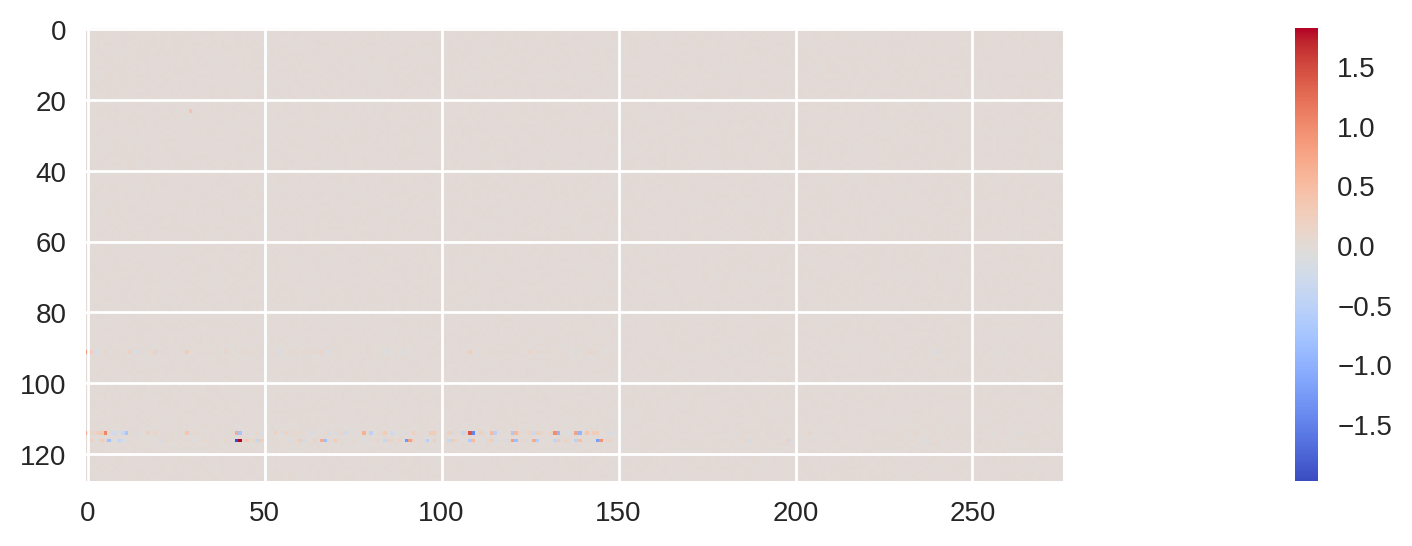

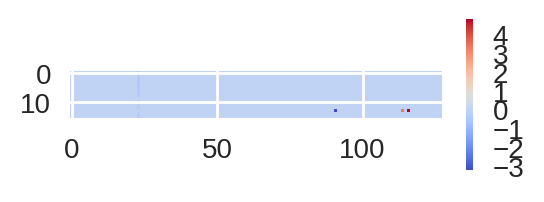

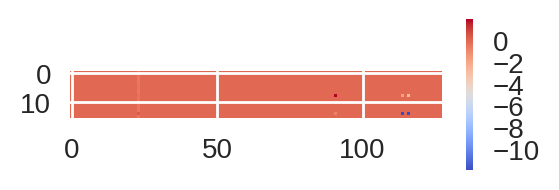

2
tp fp fn tn: 16 7 572 58888
tp fp fn tn: 5321 0 53574 588


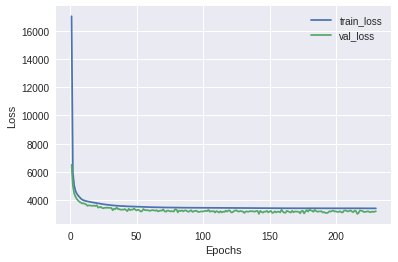

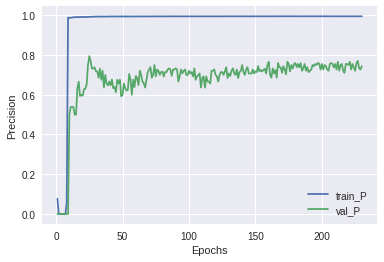

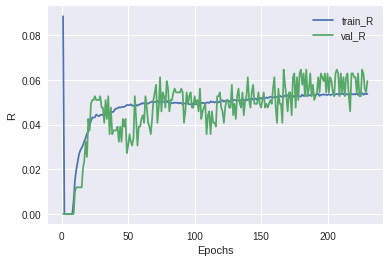

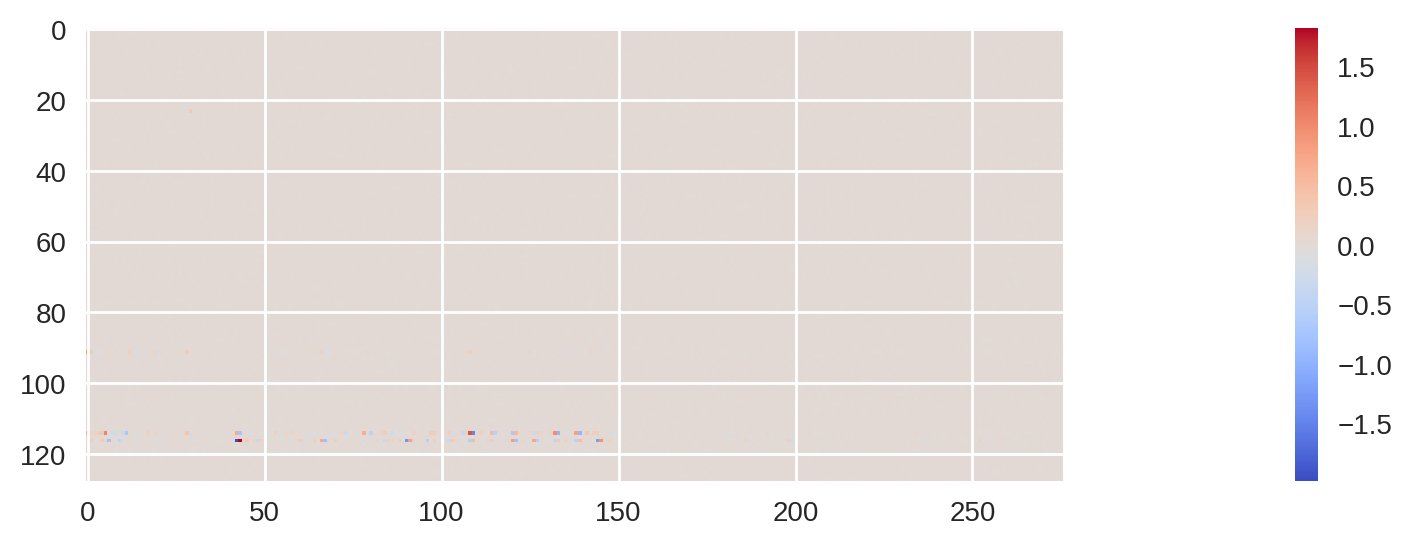

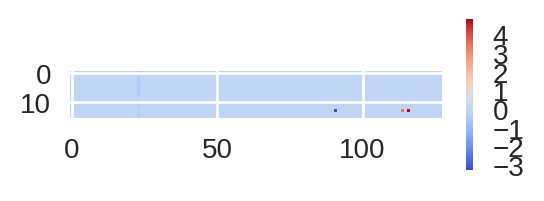

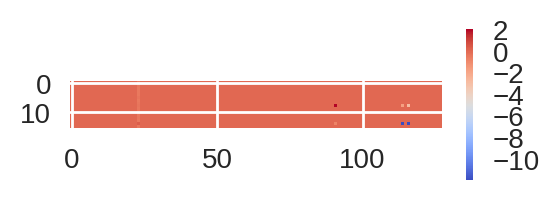

3
tp fp fn tn: 13 7 575 58888
tp fp fn tn: 5254 0 53641 588


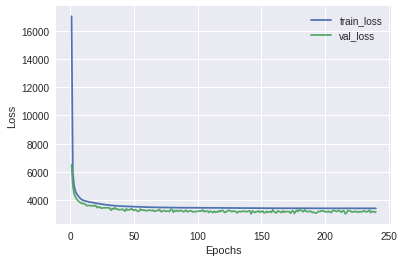

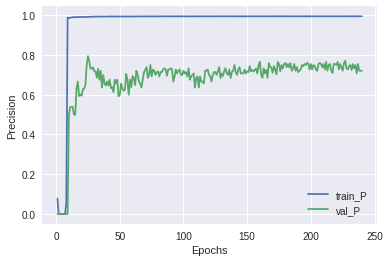

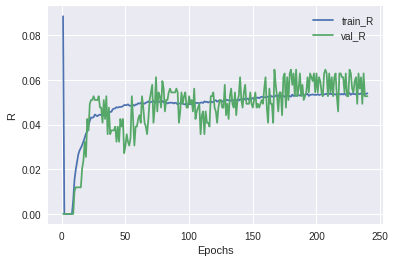

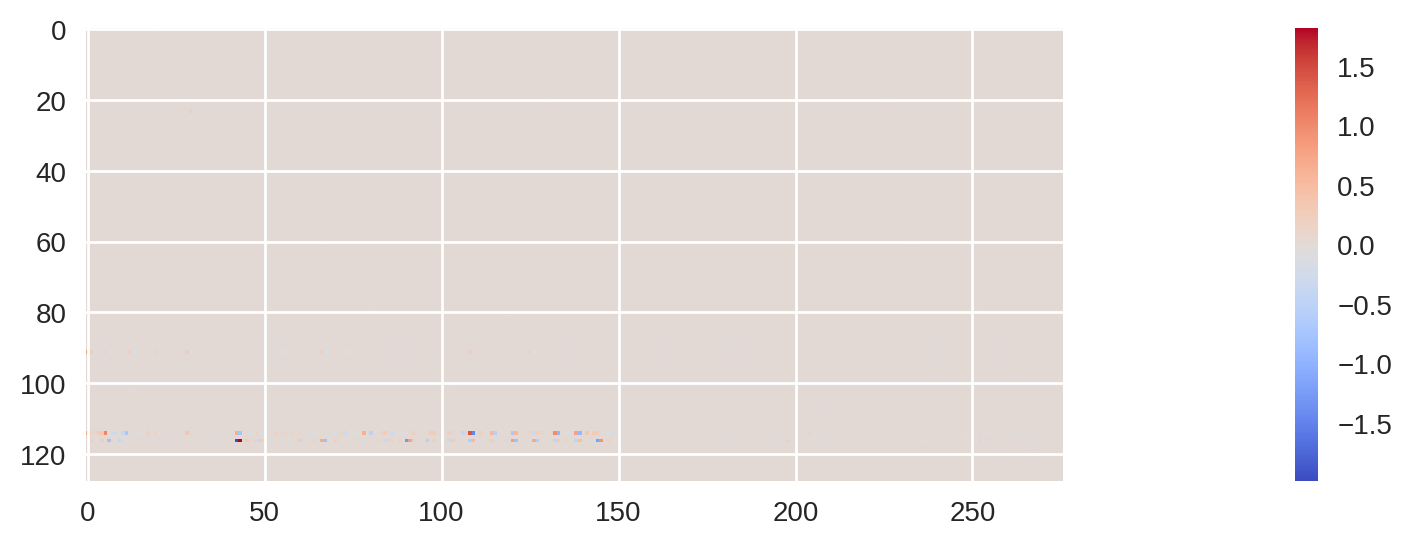

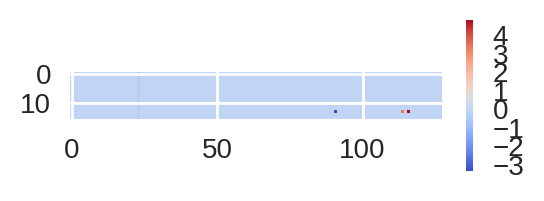

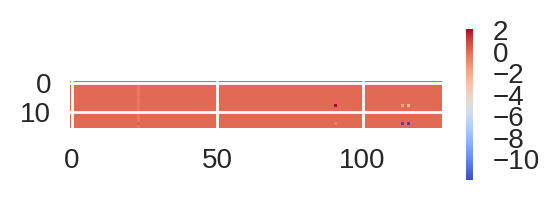

4
tp fp fn tn: 16 7 572 58888
tp fp fn tn: 5496 0 53399 588


In [0]:
for i in range(10):
  print(i)
  
  x_train = np.concatenate([x_pos, x_neg])
  y_train = np.concatenate([y_pos, y_neg])
  x_train, y_train = shuffle(x_train, y_train)

  prediction, prediction_neg = model.predict(x_val)
  evaluate(x_val, y_val, prediction)
  evaluate(x_val, 1-y_val, prediction_neg)
  #_, fp90, _, _ = evaluate(x_rec, y_rec, prediction, 0.9)

  hist = model.fit(x_train, [y_train, 1-y_train], batch_size=2**16, epochs=10, validation_data=(x_val, [y_val, 1-y_val]), verbose = False)

  loss_hist = loss_hist + hist.history['loss']
  val_loss_hist = val_loss_hist + hist.history['val_loss']
  #print(hist.history.keys())
  P_hist = P_hist + hist.history['prediction_pos_P']
  val_P_hist = val_P_hist + hist.history['val_prediction_pos_P']
  R_hist = R_hist + hist.history['prediction_pos_R']
  val_R_hist = val_R_hist + hist.history['val_prediction_pos_R']
  P_neg_hist = P_neg_hist + hist.history['prediction_neg_P']
  

  show_epochs_from = 0

  plt.plot(range(show_epochs_from + 1, len(loss_hist) + 1), loss_hist[show_epochs_from:], label='train_loss')
  plt.plot(range(show_epochs_from + 1, len(val_loss_hist) + 1), val_loss_hist[show_epochs_from:], label='val_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(range(show_epochs_from + 1, len(P_hist) + 1), P_hist[show_epochs_from:], label='train_P')
  plt.plot(range(show_epochs_from + 1, len(val_P_hist) + 1), val_P_hist[show_epochs_from:], label='val_P')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

  plt.plot(range(show_epochs_from + 1, len(R_hist) + 1), R_hist[show_epochs_from:], label='train_R')
  plt.plot(range(show_epochs_from + 1, len(val_R_hist) + 1), val_R_hist[show_epochs_from:], label='val_R')
  plt.xlabel('Epochs')
  plt.ylabel('R')
  plt.legend()
  plt.show()

  w1 = model.layers[1].get_weights()[0]
  plt.figure(figsize=(30, 3), dpi=200)
  plt.imshow(np.transpose(w1), cmap='coolwarm', interpolation='nearest')
  plt.colorbar()
  plt.show()

  w1 = model.layers[2].get_weights()[0]
  plt.figure(figsize=(3, 1), dpi=200)
  plt.imshow(np.transpose(w1), cmap='coolwarm', interpolation='nearest')
  plt.colorbar()
  plt.show()
  
  w1 = model.layers[3].get_weights()[0]
  plt.figure(figsize=(3, 1), dpi=200)
  plt.imshow(np.transpose(w1), cmap='coolwarm', interpolation='nearest')
  plt.colorbar()
  plt.show()


In [0]:
w1 = model.layers[1].get_weights()[0]
for i in range(len(w1[0])):
    print(i, end=": ")
    for j in range(len(w1)):
        if(w1[j][i] > 0.5 or w1[j][i] < -0.5):
            print("")
            print(columns[j], w1[j][i], end=" ") 
    print("")

0: 
1: 
2: 
3: 
4: 
5: 
6: 
7: 
8: 
9: 
10: 
11: 
12: 
13: 
14: 
main.dy[0].t0 -0.9827411 
main.dy[0].t1 0.62885803 
15: 
16: 
17: 
18: 
19: 
20: 
21: 
22: 
23: 
24: 
25: 
26: 
27: 
28: 
Decelerate.t0 -0.80452126 
Decelerate.t3 0.75089175 
Turn right.t4 -0.5176925 
main.Square -0.94424564 
main.Star 1.0421749 
main.dx[-4].t0 0.5963795 
main.dx[-4].t1 -0.70969355 
main.dx[-1].t0 -0.70952225 
main.dx[0].t0 -1.1313053 
main.dx[0].t1 0.99932545 
main.dx[4].t0 1.0372007 
main.dx[4].t1 -0.7905732 
main.dx[4].t2 -0.5852192 
main.dy[-3].t0 1.4169812 
main.dy[-3].t1 -1.8353738 
main.dy[-1].t0 -0.6487783 
main.dy[0].t0 -1.346559 
main.dy[0].t1 1.2633624 
main.dy[1].t0 -1.1386453 
main.dy[1].t1 0.6471072 
main.dy[2].t0 1.3747699 
main.dy[2].t1 -1.4269623 
main.dy[3].t1 -0.7967075 
29: 
30: 
31: 
Decelerate.t0 -1.5122486 
Turn left.t0 -1.5413064 
Turn right.t0 -1.0109303 
main.Square -0.6754741 
main.Star 0.96672684 
32: 
33: 
34: 
35: 
36: 
37: 
38: 
39: 
40: 
41: 
42: 
43: 
44: 
45: 
46: 
47: 
4

In [0]:
np.savetxt("weights.csv", w1, delimiter=",")

In [0]:
pred_y = model.predict(x_val)
y_val[pred_y.reshape(-1)>0.9]

In [0]:
(pred_y[y_val==1]>0.9).reshape(-1)

In [0]:
#Save

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
#Load

from keras.models import load_model
model = load_model('my_model.h5', custom_objects={'P': P, 'R': R, 'F': F})

In [0]:
#Check

pred_y = model.predict(x_val)
y_val[pred_y.reshape(-1)>0.9]

In [0]:
if True:
    data = pd.read_csv('data.csv')
    data = data.iloc[0]
    data.to_csv('columns.csv')

In [0]:
def columns():
    data = pd.read_csv('data.csv')
    return data.columns.tolist()[2:]
columns = columns()